In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import pmdarima as pm
from pmdarima.arima import auto_arima
import re
from statsmodels.tsa.stattools import adfuller


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#from pandas_datareader import data as pdr
import datetime as dt

import yfinance as yf

In [3]:
#legacy code from LSTM to retrieve prices
class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        #self.lp, self.ret = self.__get_daily_returns__() #didn't need daily returns
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [4]:
sheet_name = ['20220526','20220825','20221124','20230223','20230525']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[1]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']
symbols = symbols[symbols['Ticker_Symbol']!='TW/.L']
symbols = symbols[symbols['Ticker_Symbol']!='MDC.L']
symbols = symbols[symbols['Ticker_Symbol']!='HL/.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

0      BKG.L
1     BLND.L
2      ICP.L
4      BME.L
5      DPH.L
6     SMDS.L
7     HWDN.L
8     ABDN.L
9      HIK.L
10     CCL.L
11    CTEC.L
12    INVP.L
14    FRAS.L
15    WEIR.L
16    JMAT.L
18    DARK.L
20     IGG.L
21     BEZ.L
22    DPLM.L
23    BBOX.L
24     EMG.L
25     IMI.L
26     HSX.L
27    TATE.L
28    INCH.L
29     SXS.L
30     DRX.L
31     CCC.L
32     DLN.L
33     RSW.L
34     DLG.L
Name: Ticker_Symbol, dtype: object

In [5]:
symbols_ = symbols.set_index("Ticker_Symbol")

In [6]:
data = price_volume_data(symbols_short.to_list(),'2017-08-26', '2022-08-30')
data.pv

{'BKG.L':                                   Open         High          Low        Close  \
 Date                                                                            
 2017-08-29 00:00:00+01:00  3274.994149  3306.841742  3265.262940  3292.687256   
 2017-08-30 00:00:00+01:00  3313.034098  3313.034098  3260.839435  3273.224609   
 2017-08-31 00:00:00+01:00  3292.687154  3314.803537  3273.224737  3309.495605   
 2017-09-01 00:00:00+01:00  3304.187626  3330.727286  3290.776330  3313.034180   
 2017-09-04 00:00:00+01:00  3303.302741  3326.303778  3287.378946  3293.571533   
 ...                                ...          ...          ...          ...   
 2022-08-22 00:00:00+01:00  3792.418531  3792.418531  3702.284382  3741.051758   
 2022-08-23 00:00:00+01:00  3749.774232  3756.558523  3707.130121  3724.575439   
 2022-08-24 00:00:00+01:00  3718.760460  3729.421488  3652.855922  3674.177979   
 2022-08-25 00:00:00+01:00  3727.483054  3727.483054  3591.797243  3624.749512   
 2022-0

In [7]:
#data wrangling
#objective is to have a dataframe of close prices. columns = stocks and rows = price observations (time series)

df = data.pv[symbols_short[0]]["Close"]
for stock in symbols_short[1:]:
    
    df = pd.concat([df, data.pv[stock]["Close"]], axis = 1)

df.columns = symbols_short
df.index = pd.to_datetime(df.index.date)

In [8]:
df

Ticker_Symbol,BKG.L,BLND.L,ICP.L,BME.L,DPH.L,SMDS.L,HWDN.L,ABDN.L,HIK.L,CCL.L,...,IMI.L,HSX.L,TATE.L,INCH.L,SXS.L,DRX.L,CCC.L,DLN.L,RSW.L,DLG.L
2017-08-29,3292.687256,452.696960,689.844849,246.167709,1765.458130,349.590088,351.580872,308.022247,1125.146606,4738.056641,...,918.282654,1083.184204,554.545471,674.412292,1911.757935,234.023926,868.353455,2296.560303,4147.400879,264.271423
2017-08-30,3273.224609,454.575409,691.033630,248.356567,1769.186523,351.736938,354.142181,306.666534,1088.024780,4774.019043,...,925.641907,1097.844971,551.667969,674.412292,1911.757935,234.100174,869.208740,2321.936768,4239.029785,262.818237
2017-08-31,3309.495605,459.459229,703.713135,254.717636,1783.168335,356.245453,363.704346,306.523865,1106.585693,4832.458496,...,928.095154,1102.156982,561.945007,674.817444,1879.272705,235.014618,875.197449,2354.925293,4239.029785,263.025848
2017-09-01,3313.034180,454.575409,700.543213,253.007706,1826.046753,356.388641,367.973145,311.803833,1084.489502,4818.972168,...,932.183533,1098.707764,559.067444,676.843872,1889.830566,236.691116,873.486450,2340.545654,4296.414551,262.679779
2017-09-04,3293.571533,456.078186,689.844849,251.708130,1812.996826,354.671112,366.521790,306.309784,1057.089966,4814.476074,...,934.636780,1084.046509,554.134399,670.359192,1872.775513,237.300735,854.237244,2349.004883,4283.456055,261.434235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-22,3741.051758,428.576996,1349.345703,378.819855,3441.741699,248.167648,587.124390,140.157745,1354.822388,717.400024,...,1178.853638,884.230652,760.521729,768.922852,2740.636719,696.135193,2422.134521,2416.766357,3815.264648,212.000000
2022-08-23,3724.575439,419.840088,1341.310913,368.147614,3361.106689,245.359940,577.143921,140.250198,1326.161865,716.799988,...,1177.871216,874.488159,754.473511,762.194763,2711.522461,698.042419,2376.034912,2370.914551,3742.723633,211.800003
2022-08-24,3674.177979,409.506134,1337.057373,361.280182,3439.774902,244.816498,572.729370,138.817184,1331.505371,744.799988,...,1188.677368,866.109619,762.082642,759.311340,2741.606934,704.240845,2389.480713,2355.630615,3776.053223,209.100006
2022-08-25,3624.749512,406.781708,1338.475220,348.287811,3447.641846,241.646469,564.284363,138.077560,1315.474854,768.799988,...,1173.941650,868.447876,759.936462,755.947327,2695.994629,691.122559,2416.372070,2321.241943,3750.565918,209.600006


In [9]:
file = pd.read_csv("prediction_result_3days_200622.csv")
file = file.set_index("Unnamed: 0")

In [10]:
file

,Actual Price,Predicted Price,MSE,MAE,R2,Market Share,final_marketcap
Unnamed: 0,,,,,,,
CCL.L,1011.500000,[1102.1017],0.004354,0.065982,1,146260000,"147,941,990,000.00"
PNN.L,921.890503,[978.6994],0.094318,0.307112,1,261327008,240914886834.23047
IGG.L,652.198731,[628.6662],0.035130,0.187431,1,395398016,257878084065.0625
ITV.L,65.962585,[66.964294],0.002242,0.047346,1,4034409984,266120113306.78125
INVP.L,433.472778,[401.9024],0.167294,0.409016,1,645161984,"279,660,157,671.13"
EMG.L,240.397629,[223.5084],0.285668,0.534479,1,1199859968,288443491180.2617
TATE.L,722.515076,[747.0776],0.113386,0.336728,1,401665984,290209728829.28516
RSW.L,4005.439697,[3899.5273],0.019304,0.138940,1,72788496,291549931382.66016
IDS.L,313.700653,[276.65097],0.108747,0.329769,1,956193024,299958376095.6797


In [11]:
########################################

In [12]:
df_standardised = df.iloc[:-3].apply(lambda price: (price.iloc[:-3] - price.iloc[:-3].mean())/price.iloc[:-3].std())
df_standardised




Ticker_Symbol,BKG.L,BLND.L,ICP.L,BME.L,DPH.L,SMDS.L,HWDN.L,ABDN.L,HIK.L,CCL.L,...,IMI.L,HSX.L,TATE.L,INCH.L,SXS.L,DRX.L,CCC.L,DLN.L,RSW.L,DLG.L
2017-08-29,-1.165797,0.027938,-1.366855,-0.949972,-1.470333,0.623413,-1.370006,2.070771,-1.408819,1.533290,...,-0.627386,-0.002731,-1.044468,0.646426,-1.122482,-0.677364,-1.234105,-1.642108,-0.377055,0.859924
2017-08-30,-1.205941,0.059868,-1.363886,-0.928327,-1.465971,0.666377,-1.353128,2.039378,-1.489345,1.559168,...,-0.601918,0.051825,-1.082223,0.646426,-1.122482,-0.676856,-1.232774,-1.566835,-0.256320,0.780908
2017-08-31,-1.131128,0.142886,-1.332219,-0.865424,-1.449613,0.756603,-1.290119,2.036074,-1.449082,1.601220,...,-0.593429,0.067871,-0.947380,0.649902,-1.186375,-0.670770,-1.223449,-1.468983,-0.256320,0.792197
2017-09-01,-1.123829,0.059868,-1.340136,-0.882333,-1.399449,0.759468,-1.261990,2.158338,-1.497014,1.591515,...,-0.579280,0.055036,-0.985136,0.667288,-1.165609,-0.659613,-1.226113,-1.511637,-0.180707,0.773380
2017-09-04,-1.163973,0.085413,-1.366855,-0.895184,-1.414716,0.725096,-1.271553,2.031117,-1.556450,1.588280,...,-0.570791,0.000477,-1.049861,0.611653,-1.199154,-0.655556,-1.256086,-1.486545,-0.197781,0.705655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-12,0.149048,-0.029146,0.598979,0.401263,0.569017,-1.029280,0.566579,-1.467833,-0.654431,-1.304668,...,0.519114,-0.703937,1.865475,1.696411,0.900990,2.356886,1.301903,-0.684851,-0.422026,-1.797407
2022-08-15,0.226592,-0.001998,0.597799,0.461832,0.640345,-1.076406,0.529901,-1.468856,-0.608563,-1.306539,...,0.546311,-0.724239,1.888515,1.671673,0.992611,2.439392,1.271995,-0.667850,-0.450443,-1.672347
2022-08-16,0.158989,-0.017967,0.548222,0.582052,0.509194,-1.047405,0.537490,-1.531280,-0.617945,-1.315030,...,0.488517,-0.718438,1.929474,1.692289,0.933439,2.496511,1.248068,-0.764189,-0.533110,-1.748470
2022-08-17,-0.087563,-0.241536,0.471497,0.497623,0.536805,-1.214161,0.461605,-1.664315,-0.741996,-1.315318,...,0.372931,-0.688710,1.832196,1.597458,0.742562,2.420352,1.215168,-0.996533,-0.602861,-1.743033


In [13]:
actual_price_ls = []
ticker_mean_dict = {}
ticker_std_dict = {}
for column in df.columns:
    ticker_mean_dict[column] = df[column].iloc[:-3].mean()
    ticker_std_dict[column] = df[column].iloc[:-3].std()
    actual_price_ls.append((df[column].iloc[-1] - ticker_mean_dict[column]) / ticker_std_dict[column])
actual_price_df = pd.DataFrame(index = df.columns)
actual_price_df["actual_price"] = actual_price_ls


In [14]:
#FINAL

"""
ARIMA & NAIVE


#inputs = df, dataframe of close prices.
#outputs = dataframe of (params_dict). contains the optimized params (p, d, q) using auto-arima
        # = plots of original time series
        # = plots of results.summary() of fitting optimized params into ARIMA(p,d,q)
        # = plots of residuals
        # = plots of forecast (3 days look-ahead) 
"""


import re
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima.arima import auto_arima

def find_differencing_order(ts, look_forward):
    d = 0
                                                    
    p_value = adfuller(ts.iloc[:-(look_forward)].dropna())[1]
    while p_value > 0.05:  # Adjust the significance level as needed
        ts_interm = ts.diff().dropna()
        d += 1
        p_value = adfuller(ts_interm)[1]
    return d




####creating a function for ARIMA prediction

def get_ARIMA_PRED(standardised_df, look_forward):
    dict_ = {}
    models = {}  
    results = {}
    
    for column in standardised_df.columns:

        differencing_order = find_differencing_order(standardised_df[column], look_forward)

        best_model = auto_arima(standardised_df[column].iloc[:-(look_forward)].dropna(), start_p=0, d=differencing_order, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=True, trace=True,
                                stepwise=True, suppress_warnings=True, error_action='ignore')



        p_optimal = best_model.get_params()['order'][0]
        d_optimal = best_model.get_params()['order'][1]
        q_optimal = best_model.get_params()['order'][2]

        model_name = re.sub(r'\W+', '_', f'{column}').lower()
        models[model_name] = sm.tsa.ARIMA(standardised_df[column].iloc[:-(look_forward)].dropna(), order=(p_optimal, d_optimal, q_optimal))
        results[model_name] = models[model_name].fit()

        # Print model summary
        print(results[model_name].summary())

        # Plot the residuals to check for randomness
        # Residuals should show no predictability in variance and have a mean of 0
        residuals = results[model_name].resid
        plt.figure(figsize=(12, 6))
        plt.plot(residuals)
        plt.title('Residuals')
        plt.xlabel('Date')
        plt.ylabel('Residual Value')
        plt.show()

        # Forecast future values
        forecast_steps = look_forward  # Number of time steps to forecast ahead
        forecast = results[model_name].forecast(steps=forecast_steps)

        dict_[column] = {
            "optimal_p": p_optimal,
            "optimal_q": q_optimal,
            "optimal_d": d_optimal,
            "ARIMA_prediction": forecast.iloc[look_forward-1],  # because forecast is a Series with indexing that starts from 0, therefore we subtract 1
        }

    # Create a DataFrame to store the model information
    dict_df = pd.DataFrame(dict_)
    
    return dict_df


#import the price data for the remaining target universe at different rank dates

#dictionary to store DataFrames
dfs_target_uni = {}
params_dict_ = {}

# Loop through each sheet name and read the corresponding sheet into a DataFrame
for date in sheet_name:
    dfs_target_uni[f'df_{sheet_name}'] = pd.read_excel("target_stock_universe.xlsx", sheet_name=date)
    
    params_dict_[date] = get_ARIMA_PRED(df_standardised, 3)
    

sheet_name = ['20220524','20220823','20221122','20230221','20230523']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[0]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1260.154, Time=3.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1261.505, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1261.259, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1262.082, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1262.660, Time=0.79 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1257.893, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1261.033, Time=0.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1261.106, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1261.525, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1260.891, Time=1.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1264.581, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1263.179, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1263.425, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1262.927, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  BKG.L   No. Observations:                 1255
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 635.291
Date:                Mon, 30 Oct 2023   AIC                          -1264.581
Time:                        16:48:19   BIC                          -1249.179
Sample:                             0   HQIC                         -1258.792
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6340      0.200     -3.173      0.002      -1.026      -0.242
ma.L1          0.5782      0.210      2.757      0.006       0.167       0.989
sigma2         0.0213      0.000     51.383      0.0

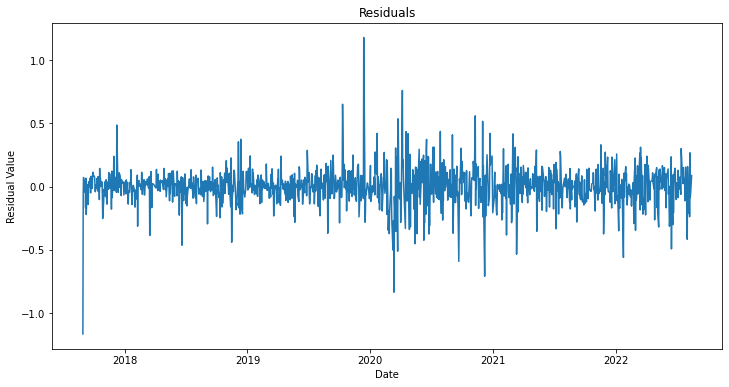

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1453.206, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1451.210, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1451.210, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1455.206, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1449.210, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.221 seconds
                               SARIMAX Results                                
Dep. Variable:                 BLND.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 728.603
Date:                Mon, 30 Oct 2023   AIC                          -1455.206
Time:                        16:48:21   BIC                          -1450.072
Sample:                             0   HQIC                         -1453.276
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


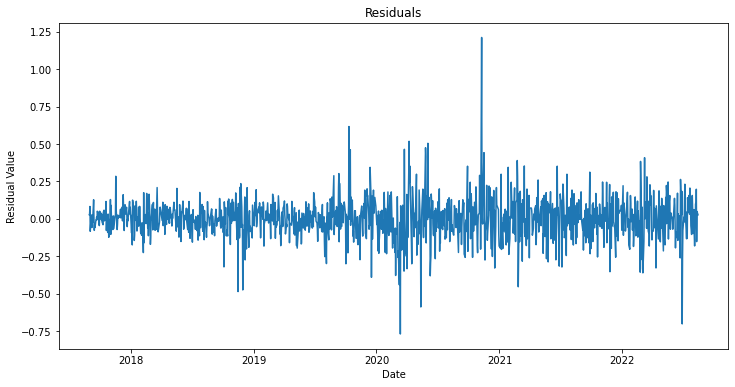

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2893.039, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2891.251, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2891.225, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2894.509, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2891.913, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.055 seconds
                               SARIMAX Results                                
Dep. Variable:                  ICP.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1448.255
Date:                Mon, 30 Oct 2023   AIC                          -2894.509
Time:                        16:48:23   BIC                          -2889.375
Sample:                             0   HQIC                         -2892.579
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


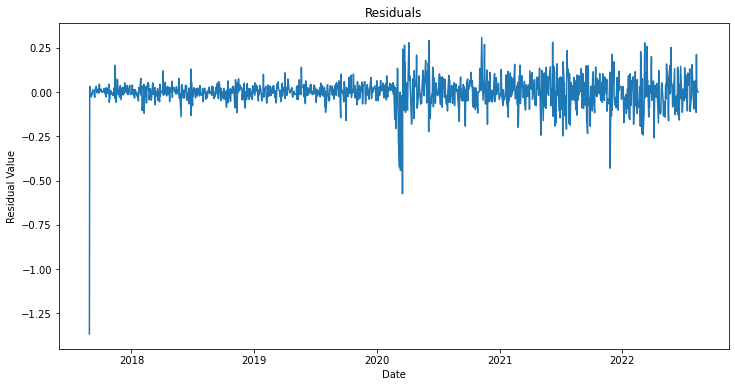

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3395.883, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3393.902, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3393.900, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3397.474, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3391.901, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.166 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

                               SARIMAX Results                                
Dep. Variable:                  BME.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1699.737
Date:                Mon, 30 Oct 2023   AIC                          -3397.474
Time:                        16:48:25   BIC                          -3392.340
Sample:                             0   HQIC                         -3395.544
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0039   6.05e-05     64.296      0.000       0.004       0.004
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              6970.11
Prob(Q):                              0.89   Pr

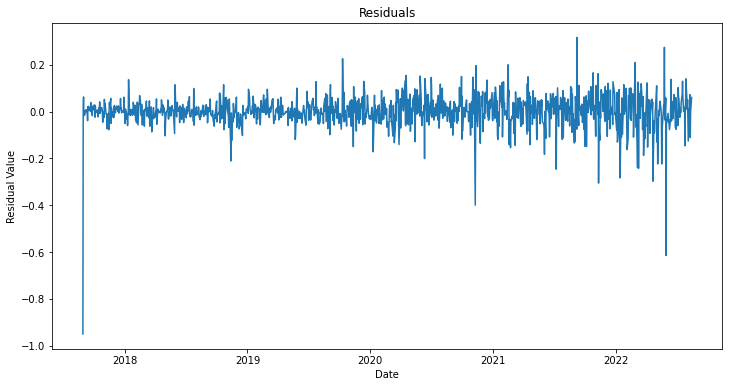

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-972.739, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1197.227, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1247.563, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-974.605, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1245.712, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1245.699, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1243.869, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1248.931, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1247.094, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1247.081, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1198.915, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1245.252, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.132 seconds
                               SARIMAX Results                                

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


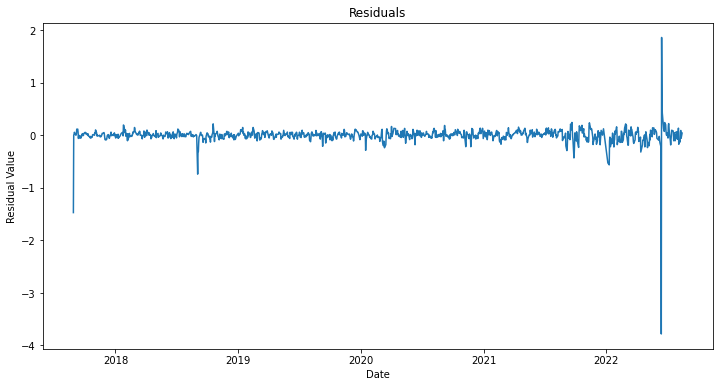

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1697.177, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1696.782, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1696.832, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1699.025, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1696.870, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.096 seconds
                               SARIMAX Results                                
Dep. Variable:                 SMDS.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 850.512
Date:                Mon, 30 Oct 2023   AIC                          -1699.025
Time:                        16:48:30   BIC                          -1693.891
Sample:                             0   HQIC                         -1697.095
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


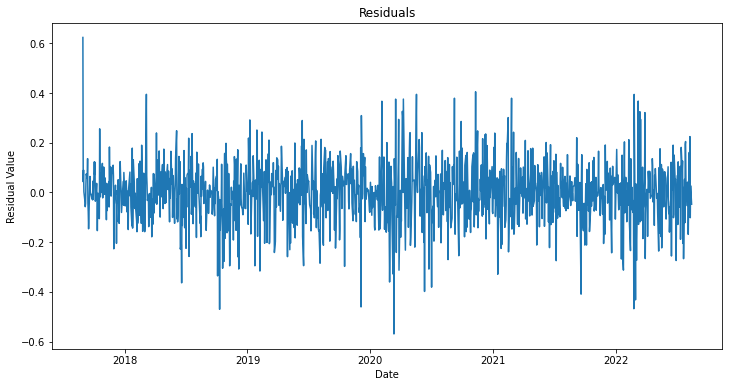

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3166.080, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3166.409, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3166.249, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3167.464, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3164.937, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.091 seconds
                               SARIMAX Results                                
Dep. Variable:                 HWDN.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1584.732
Date:                Mon, 30 Oct 2023   AIC                          -3167.464
Time:                        16:48:31   BIC                          -3162.330
Sample:                             0   HQIC                         -3165.534
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


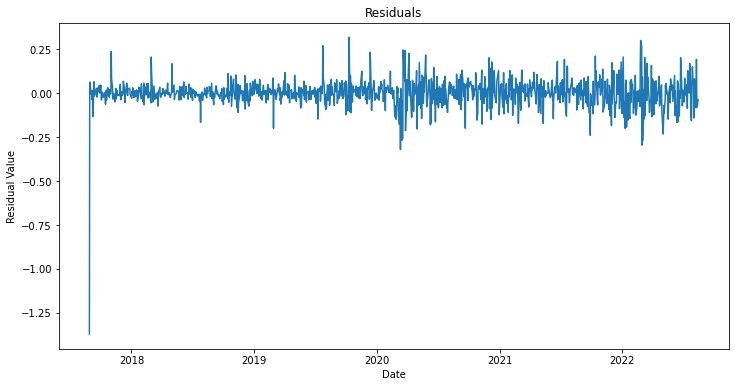

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2168.580, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2167.745, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2167.713, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2169.615, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2166.306, Time=0.70 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.416 seconds
                               SARIMAX Results                                
Dep. Variable:                 ABDN.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1085.808
Date:                Mon, 30 Oct 2023   AIC                          -2169.615
Time:                        16:48:33   BIC                          -2164.481
Sample:                             0   HQIC                         -2167.685
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


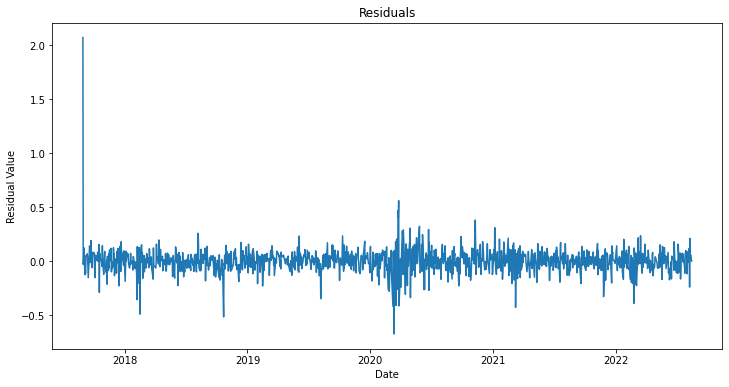

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2849.674, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2849.529, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2849.605, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2851.589, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2848.547, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.072 seconds
                               SARIMAX Results                                
Dep. Variable:                  HIK.L   No. Observations:                 1254
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1426.794
Date:                Mon, 30 Oct 2023   AIC                          -2851.589
Time:                        16:48:35   BIC                          -2846.455
Sample:                             0   HQIC                         -2849.659
                               - 1254                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


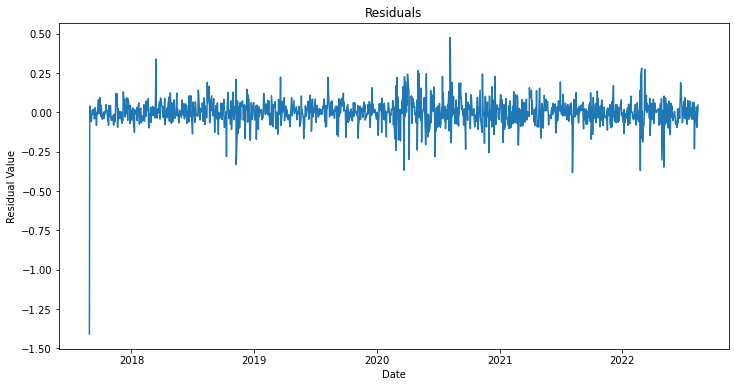

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3932.226, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3932.210, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3932.056, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3931.693, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3930.844, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.512 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  CCL.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1966.847
Date:                Mon, 30 Oct 2023   AIC                          -3931.693
Time:                        16:48:37   BIC                          -3926.559
Sample:                             0   HQIC                         -3929.763
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0025   2.78e-05     91.412      0.000       0.002       0.003
Ljung-Box (L1) (Q):                   1.99   Jarque-Bera (JB):             31735.80
Prob(Q):                              0.16   Pr

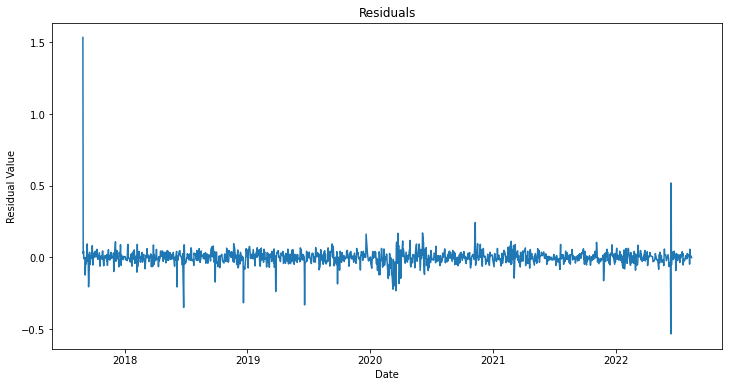

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1376.535, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1376.459, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1376.357, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1378.525, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1374.716, Time=0.92 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.677 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 CTEC.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 690.263
Date:                Mon, 30 Oct 2023   AIC                          -1378.525
Time:                        16:48:39   BIC                          -1373.391
Sample:                             0   HQIC                         -1376.595
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0195      0.000    173.366      0.000       0.019       0.020
Ljung-Box (L1) (Q):                   1.93   Jarque-Bera (JB):            466715.98
Prob(Q):                              0.16   Pr

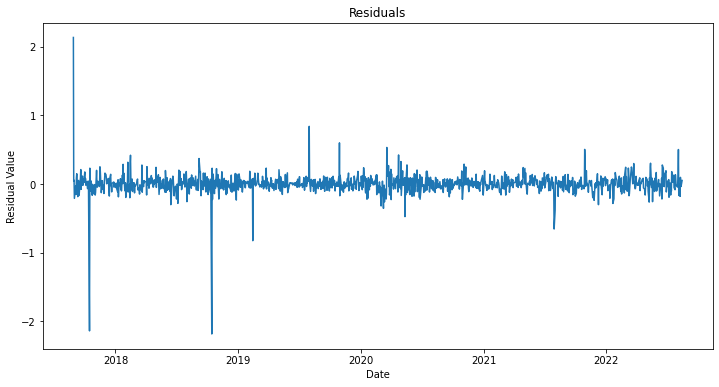

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3038.318, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3036.319, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3036.319, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3040.034, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3039.869, Time=1.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.131 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 INVP.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1521.017
Date:                Mon, 30 Oct 2023   AIC                          -3040.034
Time:                        16:48:42   BIC                          -3034.900
Sample:                             0   HQIC                         -3038.104
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0052      0.000     49.495      0.000       0.005       0.005
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1824.75
Prob(Q):                              0.99   Pr

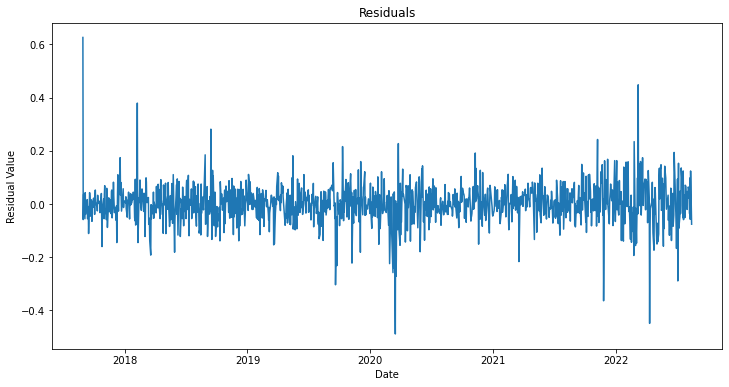

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2982.356, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2980.383, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2980.383, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2982.895, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2978.383, Time=0.55 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.166 seconds
                               SARIMAX Results                                
Dep. Variable:                 FRAS.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1492.447
Date:                Mon, 30 Oct 2023   AIC                          -2982.895
Time:                        16:48:44   BIC                          -2977.761
Sample:                             0   HQIC                         -2980.965
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


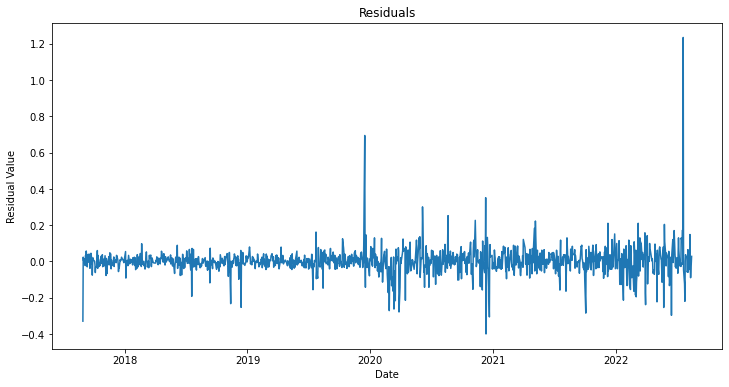

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1679.920, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1677.923, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1677.923, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1681.917, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1675.921, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.161 seconds
                               SARIMAX Results                                
Dep. Variable:                 WEIR.L   No. Observations:                 1254
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 841.959
Date:                Mon, 30 Oct 2023   AIC                          -1681.917
Time:                        16:48:45   BIC                          -1676.784
Sample:                             0   HQIC                         -1679.987
                               - 1254                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


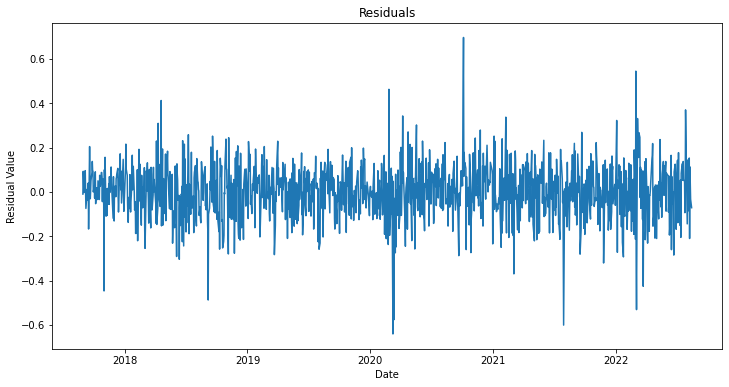

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1746.586, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1745.006, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1745.030, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1748.575, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1743.851, Time=0.67 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.354 seconds
                               SARIMAX Results                                
Dep. Variable:                 JMAT.L   No. Observations:                 1251
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 875.287
Date:                Mon, 30 Oct 2023   AIC                          -1748.575
Time:                        16:48:47   BIC                          -1743.444
Sample:                             0   HQIC                         -1746.646
                               - 1251                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


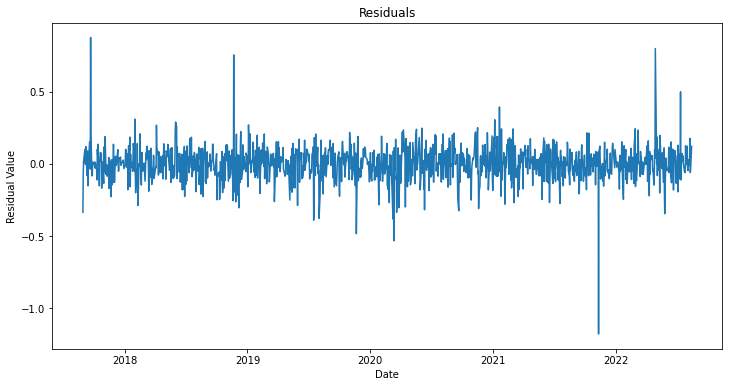

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-263.455, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-266.475, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-267.005, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-265.422, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-265.202, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-265.380, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-263.922, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-268.981, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-267.176, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-267.354, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-268.451, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-265.893, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.558 seconds
                               SARIMAX Results                                
Dep. Vari

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


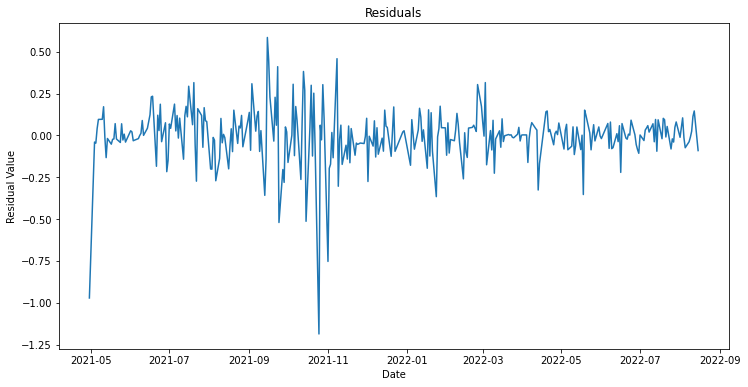

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2595.078, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2599.523, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2599.600, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2596.237, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2597.649, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2597.636, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2595.601, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2600.613, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2598.645, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2598.638, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2600.548, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2596.614, Time=0.34 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.735 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


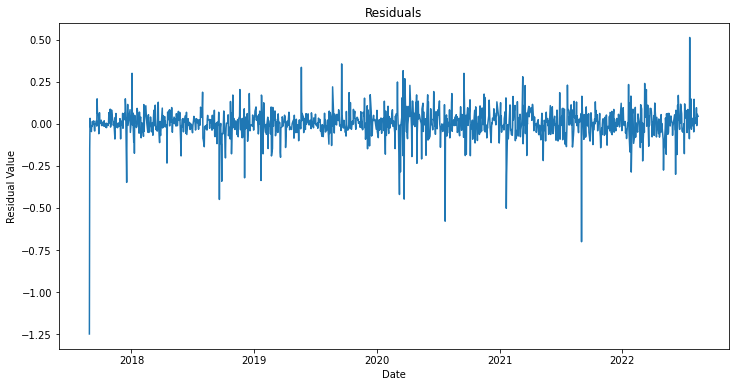

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1947.099, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1947.000, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1947.049, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1948.928, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1945.096, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.512 seconds
                               SARIMAX Results                                
Dep. Variable:                  BEZ.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 975.464
Date:                Mon, 30 Oct 2023   AIC                          -1948.928
Time:                        16:48:54   BIC                          -1943.794
Sample:                             0   HQIC                         -1946.998
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


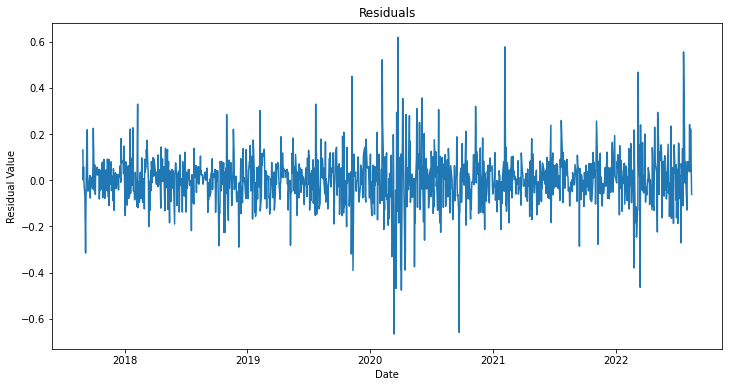

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3539.021, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3537.773, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3537.760, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3539.365, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3535.798, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.653 seconds
                               SARIMAX Results                                
Dep. Variable:                 DPLM.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1770.682
Date:                Mon, 30 Oct 2023   AIC                          -3539.365
Time:                        16:48:56   BIC                          -3534.231
Sample:                             0   HQIC                         -3537.435
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

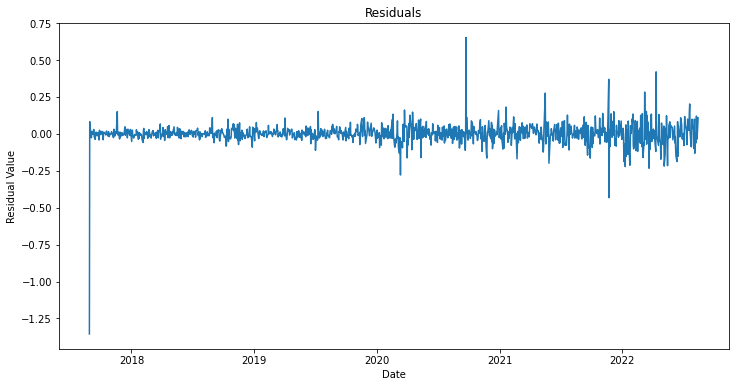

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-574.395, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-829.103, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-947.986, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-576.309, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-948.223, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-947.796, Time=1.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-944.522, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-947.970, Time=0.72 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-894.290, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-944.223, Time=0.88 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-949.396, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-949.243, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-830.888, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-948.900, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0]          

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 BBOX.L   No. Observations:                 1255
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 477.698
Date:                Mon, 30 Oct 2023   AIC                           -949.396
Time:                        16:49:05   BIC                           -933.994
Sample:                             0   HQIC                          -943.607
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0704      0.010      6.805      0.000       0.050       0.091
ma.L1         -0.6613      0.010    -68.189      0.000      -0.680      -0.642
sigma2         0.0273   6.55e-05    417.066      0.0

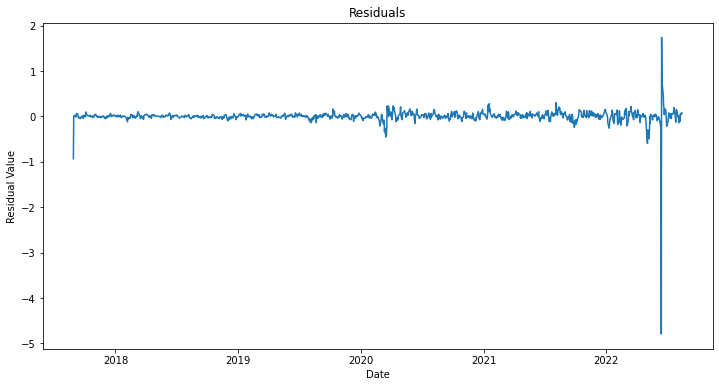

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2978.967, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2977.350, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2977.322, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2979.545, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2975.308, Time=0.92 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.716 seconds
                               SARIMAX Results                                
Dep. Variable:                  EMG.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1490.773
Date:                Mon, 30 Oct 2023   AIC                          -2979.545
Time:                        16:49:07   BIC                          -2974.411
Sample:                             0   HQIC                         -2977.615
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


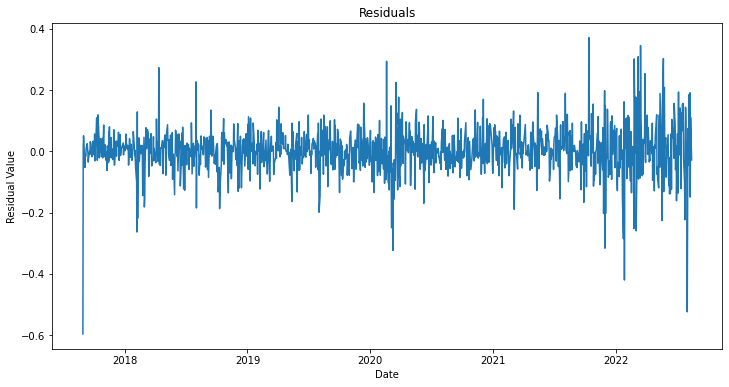

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3061.729, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3059.863, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3059.865, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3063.513, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3057.743, Time=0.51 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.150 seconds
                               SARIMAX Results                                
Dep. Variable:                  IMI.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1532.757
Date:                Mon, 30 Oct 2023   AIC                          -3063.513
Time:                        16:49:09   BIC                          -3058.379
Sample:                             0   HQIC                         -3061.583
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


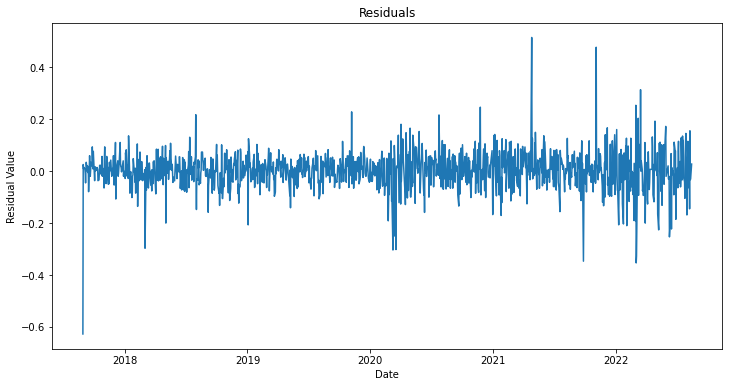

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2900.885, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2900.221, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2900.410, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2902.813, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2901.168, Time=0.72 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.714 seconds
                               SARIMAX Results                                
Dep. Variable:                  HSX.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1452.407
Date:                Mon, 30 Oct 2023   AIC                          -2902.813
Time:                        16:49:11   BIC                          -2897.679
Sample:                             0   HQIC                         -2900.883
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


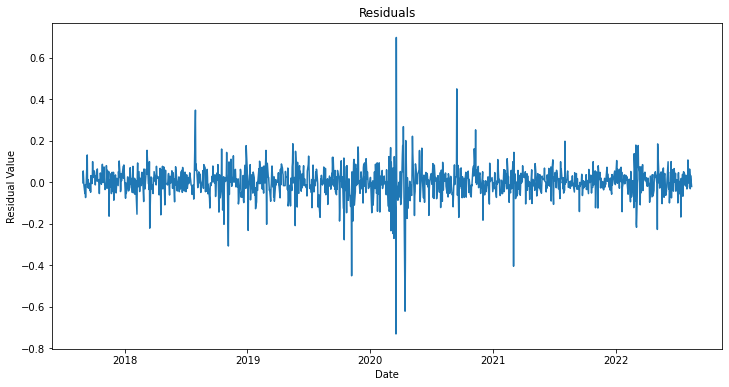

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1782.489, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1780.812, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1780.801, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1784.002, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1778.950, Time=0.84 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.675 seconds
                               SARIMAX Results                                
Dep. Variable:                 TATE.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 893.001
Date:                Mon, 30 Oct 2023   AIC                          -1784.002
Time:                        16:49:13   BIC                          -1778.868
Sample:                             0   HQIC                         -1782.072
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


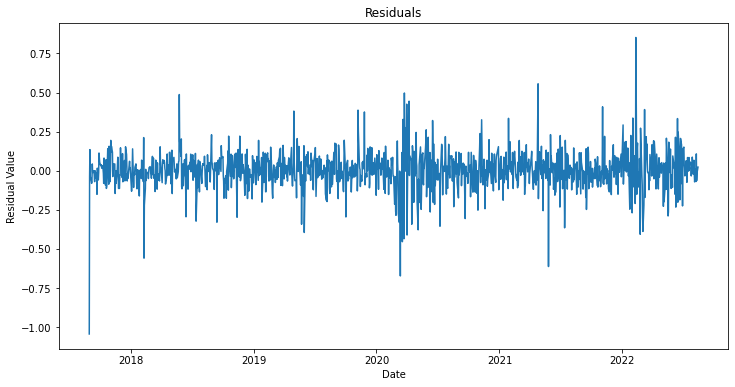

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47.803, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-264.006, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-337.790, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49.788, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-336.663, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-336.599, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-334.991, Time=1.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-339.702, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-338.569, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-338.505, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-265.971, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-336.893, Time=0.55 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.040 seconds
                               SARIMAX Results                                
Dep. Variab

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


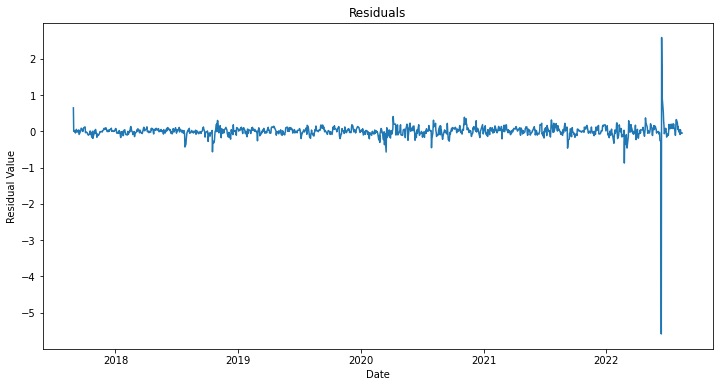

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2545.938, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2550.431, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2550.248, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2547.473, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2548.629, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2548.674, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2546.587, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2551.897, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2550.109, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2550.152, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2551.709, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2548.075, Time=0.51 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.232 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


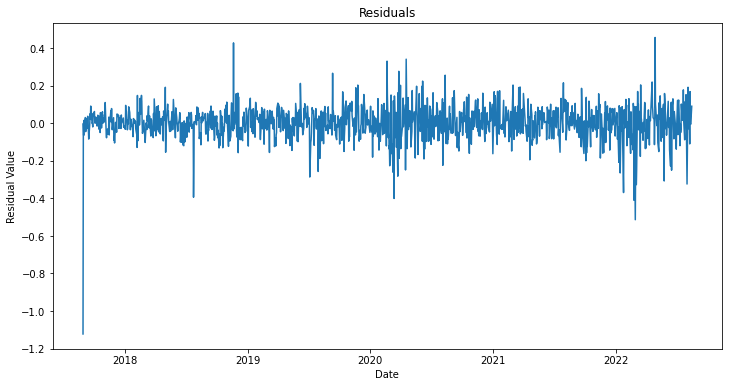

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3581.294, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3582.862, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3582.636, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3580.988, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3582.206, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3581.489, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3580.205, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3582.308, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.040 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  DRX.L   No. Observations:                 1255
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1793.154
Date:                Mon, 30 Oct 2023   AIC                          -3582.308
Time:                        16:49:24   BIC                          -3572.039
Sample:                             0   HQIC                         -3578.448
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0515      0.017     -3.047      0.002      -0.085      -0.018
sigma2         0.0034   3.99e-05     84.088      0.000       0.003       0.003
Ljung-Box (L1) (Q):                   0.00   Jarque-

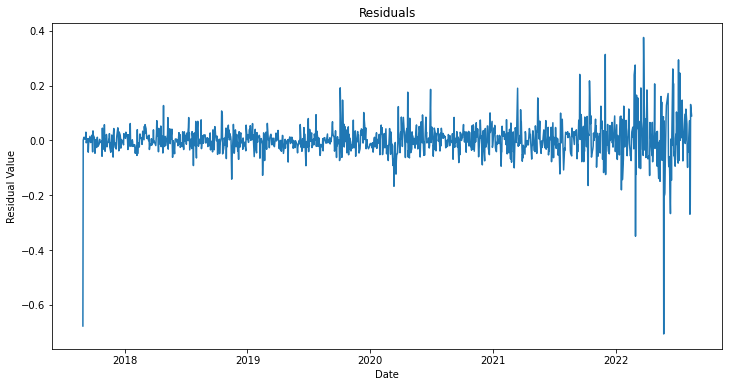

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3728.690, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3726.913, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3726.906, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3729.013, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3724.762, Time=0.53 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.776 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

                               SARIMAX Results                                
Dep. Variable:                  CCC.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1865.506
Date:                Mon, 30 Oct 2023   AIC                          -3729.013
Time:                        16:49:26   BIC                          -3723.879
Sample:                             0   HQIC                         -3727.083
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0030   5.46e-05     54.747      0.000       0.003       0.003
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              2989.06
Prob(Q):                              0.64   Pr

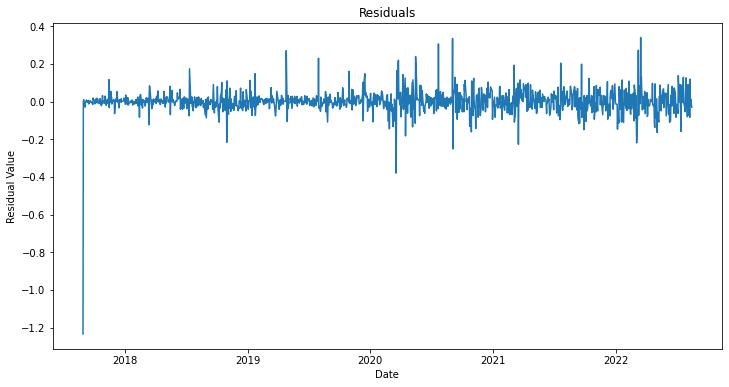

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1423.098, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1421.101, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1421.101, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1425.057, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1419.999, Time=1.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.801 seconds
                               SARIMAX Results                                
Dep. Variable:                  DLN.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 713.529
Date:                Mon, 30 Oct 2023   AIC                          -1425.057
Time:                        16:49:29   BIC                          -1419.923
Sample:                             0   HQIC                         -1423.128
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


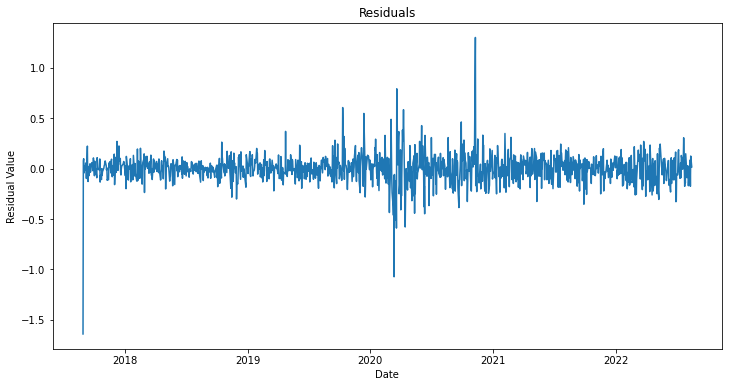

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1373.620, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1371.711, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1371.717, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1375.620, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1374.392, Time=1.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.749 seconds
                               SARIMAX Results                                
Dep. Variable:                  RSW.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 688.810
Date:                Mon, 30 Oct 2023   AIC                          -1375.620
Time:                        16:49:31   BIC                          -1370.486
Sample:                             0   HQIC                         -1373.690
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


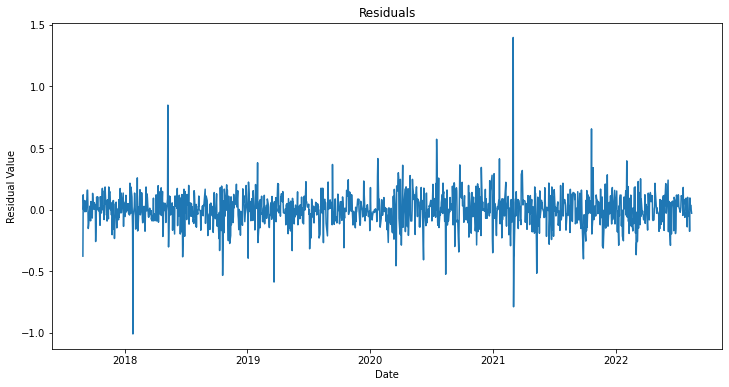

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3556.016, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-307.402, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2182.804, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3554.037, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-311.075, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-314.283, Time=0.34 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-312.858, Time=0.42 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-312.498, Time=1.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-304.103, Time=1.16 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-319.884, Time=1.63 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-320.851, Time=2.44 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-313.008, Time=1.81 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-320.399, Time=3.02 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(4,0,2)(0,0,0)[0]             : 

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting param

                               SARIMAX Results                                
Dep. Variable:                  DLG.L   No. Observations:                 1254
Model:                 ARIMA(4, 0, 2)   Log Likelihood                 168.762
Date:                Mon, 30 Oct 2023   AIC                           -321.524
Time:                        16:49:58   BIC                           -280.451
Sample:                             0   HQIC                          -306.086
                               - 1254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0461      0.296      0.156      0.876      -0.534       0.626
ar.L1         -0.3166      0.136     -2.335      0.020      -0.582      -0.051
ar.L2          0.8016      0.072     11.105      0.0

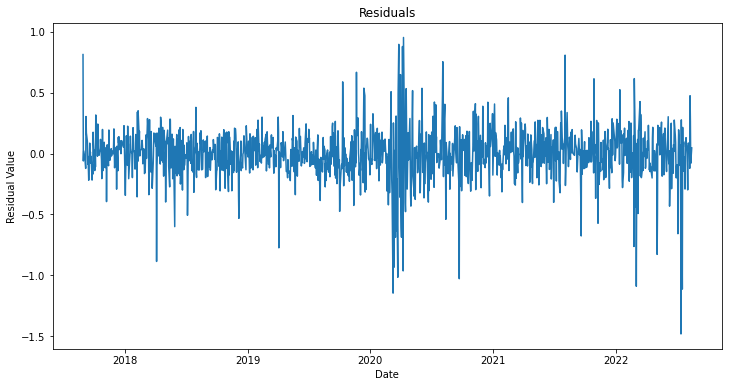

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [15]:
look_forward = 3
dict_df = get_ARIMA_PRED(df_standardised, look_forward)

In [16]:
dict_df_T = dict_df.T
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction
BKG.L,1.0,1.0,1.0,0.227786
BLND.L,0.0,0.0,1.0,-0.001998
ICP.L,0.0,0.0,1.0,0.597799
BME.L,0.0,0.0,1.0,0.461832
DPH.L,0.0,1.0,1.0,0.618607
SMDS.L,0.0,0.0,1.0,-1.076406
HWDN.L,0.0,0.0,1.0,0.529901
ABDN.L,0.0,0.0,1.0,-1.468856
HIK.L,0.0,0.0,1.0,-0.608563
CCL.L,0.0,0.0,1.0,-1.306539


In [17]:
###############################


#PRODUCE NAIVE PREDICTION
naive_predictions = []
for column in df_standardised.columns:
    naive_predictions.append(df_standardised[column].iloc[-4])
dict_df_T["naive_prediction"] = naive_predictions


In [18]:
#verifying that the naive prediction is identical with the actual price.iloc[-4]

df_standardised.iloc[-4] == dict_df_T["naive_prediction"]

Ticker_Symbol
BKG.L     True
BLND.L    True
ICP.L     True
BME.L     True
DPH.L     True
SMDS.L    True
HWDN.L    True
ABDN.L    True
HIK.L     True
CCL.L     True
CTEC.L    True
INVP.L    True
FRAS.L    True
WEIR.L    True
JMAT.L    True
DARK.L    True
IGG.L     True
BEZ.L     True
DPLM.L    True
BBOX.L    True
EMG.L     True
IMI.L     True
HSX.L     True
TATE.L    True
INCH.L    True
SXS.L     True
DRX.L     True
CCC.L     True
DLN.L     True
RSW.L     True
DLG.L     True
dtype: bool

In [19]:
dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]

BKG.L     False
BLND.L    False
ICP.L      True
BME.L      True
DPH.L     False
SMDS.L     True
HWDN.L     True
ABDN.L     True
HIK.L      True
CCL.L      True
CTEC.L    False
INVP.L    False
FRAS.L     True
WEIR.L    False
JMAT.L     True
DARK.L    False
IGG.L     False
BEZ.L      True
DPLM.L     True
BBOX.L    False
EMG.L      True
IMI.L      True
HSX.L      True
TATE.L     True
INCH.L    False
SXS.L     False
DRX.L     False
CCC.L      True
DLN.L      True
RSW.L      True
DLG.L     False
dtype: bool

In [20]:
(dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]).value_counts()

True     18
False    13
Name: count, dtype: int64

In [21]:
param_df = dict_df_T[dict_df_T["ARIMA_prediction"] != dict_df_T["naive_prediction"]]
param_df

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction
BKG.L,1.0,1.0,1.0,0.227786,0.226592
BLND.L,0.0,0.0,1.0,-0.001998,-0.001998
DPH.L,0.0,1.0,1.0,0.618607,0.640345
CTEC.L,0.0,0.0,1.0,1.641823,1.641823
INVP.L,0.0,0.0,1.0,1.984304,1.984304
WEIR.L,0.0,0.0,1.0,0.238208,0.238208
DARK.L,0.0,1.0,1.0,-0.465577,-0.453196
IGG.L,0.0,1.0,1.0,1.535781,1.538941
BBOX.L,1.0,1.0,1.0,1.013326,1.065669
INCH.L,0.0,1.0,1.0,1.696978,1.671673


In [22]:
#create a new dataframe for comparison of analysis

comparision_df = pd.DataFrame(index = param_df.index)

In [23]:
#file["Actual Price"].index = dict_df_T.index.to_list()
comparision_df["ARIMA_prediction"]=param_df["ARIMA_prediction"]
comparision_df["naive_prediction"]=param_df["naive_prediction"]

In [24]:
comparision_df["Actual Price, y"] = actual_price_df.loc[comparision_df.index].values 


In [25]:
comparision_df["SE_ARIMA"] =\
(
    np.square(comparision_df["ARIMA_prediction"].values - comparision_df["Actual Price, y"].values) 
)

comparision_df["SE_naive"] =\
(
    np.square(comparision_df["naive_prediction"].values - actual_price_df["actual_price"].loc[param_df.index].values)
)
comparision_df.head(3)

,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
BKG.L,0.227786,0.226592,-0.540937,0.590936,0.589101
BLND.L,-0.001998,-0.001998,-0.773143,0.594665,0.594665
DPH.L,0.618607,0.640345,0.421010,0.039045,0.048108


In [26]:
dict_df_T["Actual Price, y"] = actual_price_df.loc[dict_df_T.index].values


In [27]:
dict_df_T["SE_ARIMA"] =\
(
    np.square(dict_df_T["ARIMA_prediction"].values - dict_df_T["Actual Price, y"].values) 
)

dict_df_T["SE_naive"] =\
(
    np.square(dict_df_T["naive_prediction"].values - dict_df_T["Actual Price, y"].values)
)
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
BKG.L,1.0,1.0,1.0,0.227786,0.226592,-0.540937,0.590936,0.589101
BLND.L,0.0,0.0,1.0,-0.001998,-0.001998,-0.773143,0.594665,0.594665
ICP.L,0.0,0.0,1.0,0.597799,0.597799,0.146316,0.203837,0.203837
BME.L,0.0,0.0,1.0,0.461832,0.461832,0.008635,0.205387,0.205387
DPH.L,0.0,1.0,1.0,0.618607,0.640345,0.421010,0.039045,0.048108
SMDS.L,0.0,0.0,1.0,-1.076406,-1.076406,-1.642335,0.320275,0.320275
HWDN.L,0.0,0.0,1.0,0.529901,0.529901,-0.054965,0.342068,0.342068
ABDN.L,0.0,0.0,1.0,-1.468856,-1.468856,-1.904725,0.189981,0.189981
HIK.L,0.0,0.0,1.0,-0.608563,-0.608563,-1.031973,0.179276,0.179276
CCL.L,0.0,0.0,1.0,-1.306539,-1.306539,-1.331787,0.000637,0.000637


In [28]:
#market share extraction. market share on rank date strictly

tickers = symbols_short

def extract_sp(stocks, start, end):
    def data(ticker):
        return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
    FAANG_Stock = map(data, stocks)
    return(pd.concat(FAANG_Stock,
                     keys = stocks,
                     names = ["Company", "Date"]
                    )
          )


result_ = extract_sp(tickers,start="2022-08-26", end="2022-08-30")
result_df = pd.DataFrame(result_, columns = ['Market Share'])
market_share_df_strict =\
(
    result_df
    .reset_index()
    .sort_values(by='Date', ascending = False)
    .drop_duplicates(subset='Company', keep='last')

)

market_share_df_strict

,Company,Date,Market Share
8,SXS.L,2022-08-30 00:00:00+01:00,105712000
2,HWDN.L,2022-08-29 00:00:00+01:00,555678016
0,BKG.L,2022-08-26 00:00:00+01:00,109229000
1,BME.L,2022-08-26 00:00:00+01:00,1001230016
3,INVP.L,2022-08-26 00:00:00+01:00,696083008
4,BBOX.L,2022-08-26 00:00:00+01:00,1868829952
5,EMG.L,2022-08-26 00:00:00+01:00,1292029952
7,INCH.L,2022-08-26 00:00:00+01:00,374494016


In [29]:
### market share NEAR rank date

def extract_sp(stocks, start, end):
    def data(ticker):
        return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
    FAANG_Stock = map(data, stocks)
    return(pd.concat(FAANG_Stock,
                     keys = stocks,
                     names = ["Company", "Date"]
                    )
          )

#tickers = ['AAPL','MSFT']

tickers = symbols_short

result_ = extract_sp(tickers,start="2015-05-23", end="2022-08-30")
result_df = pd.DataFrame(result_, columns = ['Market Share'])
market_share_df =\
(
    result_df
    .reset_index()
    .sort_values(by='Date', ascending = False)
    .drop_duplicates(subset='Company', keep='first')

)

market_share_df

,Company,Date,Market Share
5982,EMG.L,2022-08-30 00:00:00+01:00,1291090048
7789,SXS.L,2022-08-30 00:00:00+01:00,105712000
2118,HWDN.L,2022-08-29 00:00:00+01:00,555678016
5171,BBOX.L,2022-08-26 00:00:00+01:00,1868829952
379,BKG.L,2022-08-26 00:00:00+01:00,109229000
7367,INCH.L,2022-08-26 00:00:00+01:00,374494016
1172,BME.L,2022-08-26 00:00:00+01:00,1001230016
3357,INVP.L,2022-08-26 00:00:00+01:00,696083008
4469,IGG.L,2022-08-24 00:00:00+01:00,429227008
2172,ABDN.L,2022-08-24 00:00:00+01:00,2157649920


In [30]:
#checking for stock that doesnt have market share extracted


dict_df_T.index[~dict_df_T.index.isin(market_share_df["Company"].to_list())]

Index([], dtype='object')

In [31]:
market_share_df_ = market_share_df.set_index("Company")
ordered_market_share_df = market_share_df_.loc[dict_df_T.index]
ordered_market_share_df

,Date,Market Share
BKG.L,2022-08-26 00:00:00+01:00,109229000
BLND.L,2022-08-19 00:00:00+01:00,927001024
ICP.L,2022-08-12 00:00:00+01:00,290552000
BME.L,2022-08-26 00:00:00+01:00,1001230016
DPH.L,2022-08-13 00:00:00+01:00,113764000
SMDS.L,2022-08-03 00:00:00+01:00,1376470016
HWDN.L,2022-08-29 00:00:00+01:00,555678016
ABDN.L,2022-08-24 00:00:00+01:00,2157649920
HIK.L,2022-08-18 00:00:00+01:00,220124992
CCL.L,2022-08-14 00:00:00+01:00,1181090048


In [32]:
#un-normalise the actual_price
ticker_mean_df = pd.Series(ticker_mean_dict.values(), index = ticker_mean_dict.keys())
ticker_std_df = pd.Series(ticker_std_dict.values(), index = ticker_std_dict.keys())

dict_df_T["un-normalised_actual_mrkt_share"] = pd.Series((actual_price_df.values.flatten() * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_ARIMA_pred_mrkt_share"] = pd.Series((dict_df_T["ARIMA_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_naive_pred_mrkt_share"] = pd.Series((dict_df_T["naive_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
result = dict_df_T[["un-normalised_actual_mrkt_share", "un-normalised_ARIMA_pred_mrkt_share", "un-normalised_naive_pred_mrkt_share"]].mul(ordered_market_share_df["Market Share"], axis=0)
result


,un-normalised_actual_mrkt_share,un-normalised_ARIMA_pred_mrkt_share,un-normalised_naive_pred_mrkt_share
BKG.L,3.927519e+11,4.334147e+11,4.333515e+11
BLND.L,3.759550e+11,4.179671e+11,4.179671e+11
ICP.L,3.765377e+11,4.290046e+11,4.290046e+11
BME.L,3.436058e+11,3.894426e+11,3.894426e+11
DPH.L,3.848341e+11,4.040308e+11,4.061427e+11
SMDS.L,3.250143e+11,3.639809e+11,3.639809e+11
HWDN.L,3.063080e+11,3.555730e+11,3.555730e+11
ABDN.L,2.933350e+11,3.340509e+11,3.340509e+11
HIK.L,2.857194e+11,3.286757e+11,3.286757e+11
CCL.L,8.860538e+11,9.275356e+11,9.275356e+11


In [33]:
symbols['Ticker'] = symbols['Ticker'].str.split(' ').str[0]
symbols['Ticker'] = symbols['Ticker'] + ".L"
symbols.head(3)

,Ticker,Name,Weight,Shares,Price,Market Cap,SEDOL,ISIN,Index,Ticker_Symbol
0,BKG.L,Berkeley Group Holdings PLC,0.203024,103.263948,3843.0,4204059136,BLJNXL8,GB00BLJNXL82,FTSE100,BKG.L
1,BLND.L,British Land Co PLC/The,0.211259,924.007102,446.9,4142766336,0136701,GB0001367019,FTSE100,BLND.L
2,ICP.L,Intermediate Capital Group PLC,0.201690,277.826273,1419.0,4122939648,BYT1DJ1,GB00BYT1DJ19,FTSE100,ICP.L


In [34]:
#result is the prediction results
result2 = result.reset_index().rename(columns = {"index": "Ticker"})
merged = result2.merge(symbols, how='left', on='Ticker') #target universe is list before rank date
merged.head(3)

,Ticker,un-normalised_actual_mrkt_share,un-normalised_ARIMA_pred_mrkt_share,un-normalised_naive_pred_mrkt_share,Name,Weight,Shares,Price,Market Cap,SEDOL,ISIN,Index,Ticker_Symbol
0,BKG.L,3.927519e+11,4.334147e+11,4.333515e+11,Berkeley Group Holdings PLC,0.203024,103.263948,3843.0,4204059136,BLJNXL8,GB00BLJNXL82,FTSE100,BKG.L
1,BLND.L,3.759550e+11,4.179671e+11,4.179671e+11,British Land Co PLC/The,0.211259,924.007102,446.9,4142766336,0136701,GB0001367019,FTSE100,BLND.L
2,ICP.L,3.765377e+11,4.290046e+11,4.290046e+11,Intermediate Capital Group PLC,0.201690,277.826273,1419.0,4122939648,BYT1DJ1,GB00BYT1DJ19,FTSE100,ICP.L


In [35]:
## 90percentile decision module + confusion matrix 

In [37]:
#this is the decision module
def get_top10(merged_df, column):
    merged_df2 = merged_df.sort_values(by=column, ascending = False).reset_index(drop=True)
    ftse_250 = merged_df2[merged_df2["Index"] =='FTSE250']
    ftse_100 = merged_df2[merged_df2["Index"] =='FTSE100']

    # list of stocks that is going into FTSE100
    stocks_into_FTSE100 = ftse_250[ftse_250.index<ftse_100.index[0]]['Ticker'].to_list()

    # number of stocks that is going into FTSE100
    number_of_stocks = len(stocks_into_FTSE100)

    # list of stocks that is going out from FTSE100
    stocks_out_from_FTSE100 = ftse_100['Ticker'].tail(number_of_stocks).to_list()
    
    return stocks_into_FTSE100, stocks_out_from_FTSE100

stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive = get_top10(merged, "un-normalised_naive_pred_mrkt_share")
stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA = get_top10(merged, "un-normalised_ARIMA_pred_mrkt_share")


date = "2022-09-20"

def confusion_matrix(stocks_into_FTSE100, stocks_out_from_FTSE100, date):
    post_rebalancing = pd.read_csv("ftse100_rebalancing_summary.csv")
    post_rebalancing_ = post_rebalancing[post_rebalancing["Post Date"] ==  date]
    
    post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
    post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"

    true_positive_100 =\
    (
        post_rebalancing_[post_rebalancing_["FTSE100"] == -1.0]["Ticker"]
    )
    true_negative_100 =\
    (
        post_rebalancing_[post_rebalancing_["FTSE100"] == 1.0]["Ticker"]
    )
#     true_positive_250 =\
#     (
#         post_rebalancing_[post_rebalancing_["FTSE250"] == 1.0]["Ticker"]
#     )
#     true_negative_250 =\
#     (
#         post_rebalancing_[post_rebalancing_["FTSE250"] == -1.0]["Ticker"]
#     )
    
    true_positive_count = 0
    true_negative_count = 0
    
    for outgoing in stocks_out_from_FTSE100:
        if true_positive_100.isin([outgoing]).any():
            true_positive_count+=1
    
    for incoming in stocks_into_FTSE100:
        if true_negative_100.isin([incoming]).any():
            true_negative_count+=1
            
    #reconfirm the top10 predicted
    going_up_length = len(stocks_into_FTSE100)

    retained_in_top10 = list(symbols["Ticker"].iloc[:10 - going_up_length].values)
    retained_in_top10.extend(stocks_into_FTSE100)

    #reconfirm the bottom 25 predicted
    coming_down_length = len(stocks_out_from_FTSE100)

    retained_in_bottom25 = list(symbols["Ticker"].iloc[(10 + coming_down_length):].values)
    retained_in_bottom25.extend(stocks_into_FTSE100)
    
    
#     true_positive = true_positive_count / len(retained_in_top10 + retained_in_bottom25)
#     false_positive = (len(retained_in_top10)-true_positive_count) / len(retained_in_top10 + retained_in_bottom25)
#     true_negative = true_negative_count / len(retained_in_top10 + retained_in_bottom25)
#     false_negative = (len(retained_in_bottom25)-true_negative_count) / len(retained_in_top10 + retained_in_bottom25)
    
    true_positive = true_positive_count / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    false_positive = (len(stocks_out_from_FTSE100) - true_positive_count) / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    true_negative = true_negative_count / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    false_negative = (len(stocks_into_FTSE100) - true_negative_count) / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    
    #can return retained_in_top10 and retained_in_bottom25 to know the ordered prediction of top10&bottom25 if we want
    return true_positive, false_positive, true_negative, false_negative
    

In [38]:
true_positive_naive, false_positive_naive, true_negative_naive, false_negative_naive = confusion_matrix(stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive, date)
true_positive_ARIMA, false_positive_ARIMA, true_negative_ARIMA, false_negative_ARIMA = confusion_matrix(stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA, date)


/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5846/588011625.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5846/588011625.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5846/588011625.py:28: SettingWithCopyWarning: 
A value

In [39]:
#logic check, must sum to 1
sum(confusion_matrix(stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive,date))

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5846/588011625.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5846/588011625.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"


1.0

In [40]:
#logic check, must sum to 1
sum(confusion_matrix(stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA,date))

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5846/588011625.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5846/588011625.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"


1.0

In [41]:
print("Percentage of true positive in naive model is {:.3f}%".format(true_positive_naive*100))
print("Percentage of true negative in naive model is {:.3f}%".format(true_negative_naive*100))
print("Percentage of false positive in naive model is {:.3f}%".format(false_positive_naive*100))
print("Percentage of false negative in naive model is {:.3f}%".format(false_negative_naive*100))

Percentage of true positive in naive model is 50.000%
Percentage of true negative in naive model is 25.000%
Percentage of false positive in naive model is 0.000%
Percentage of false negative in naive model is 25.000%


In [42]:
print("Percentage of true positive in ARIMA model is {:.3f}%".format(true_positive_ARIMA*100))
print("Percentage of true negative in ARIMA model is {:.3f}%".format(true_negative_ARIMA*100))
print("Percentage of false positive in ARIMA model is {:.3f}%".format(false_positive_ARIMA*100))
print("Percentage of false negative in ARIMA model is {:.3f}%".format(false_negative_ARIMA*100))

Percentage of true positive in ARIMA model is 50.000%
Percentage of true negative in ARIMA model is 25.000%
Percentage of false positive in ARIMA model is 0.000%
Percentage of false negative in ARIMA model is 25.000%


In [43]:
#param_df shows us the parameters that gave different ARIMA and Naive predictions

In [44]:
#same false positive between ARIMA and NAIVE.